<a href="https://www.kaggle.com/code/nicholas33/02-aneurysmnet-cnn-intracranial-training-nb153?scriptVersionId=256745340" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# ====================================================
# RSNA INTRACRANIAL ANEURYSM DETECTION - TRAINING PIPELINE
# ====================================================

import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pydicom
import nibabel as nib
import cv2
from scipy import ndimage
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Limit excessive threading in CPU libs to reduce contention
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('MKL_NUM_THREADS', '1')
try:
    cv2.setNumThreads(0)
except Exception:
    pass

# Seeding for reproducibility
def set_global_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    try:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass

set_global_seed(42)

In [2]:
# ====================================================
# CELL 2: CONFIGURATION
# ====================================================

class Config:
    # Paths
    TRAIN_CSV_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv'
    LOCALIZER_CSV_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv'
    SERIES_DIR = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
    SEGMENTATION_DIR = '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/'
    
    # Stage 1: 3D Segmentation
    STAGE1_TARGET_SIZE = (48, 112, 112)  # Moderately reduced for speed
    STAGE1_BATCH_SIZE = 32
    STAGE1_EPOCHS = 15
    STAGE1_LR = 1e-4
    
    # General
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MIXED_PRECISION = True
    CUDNN_BENCHMARK = True
    N_FOLDS = 3
    
    # Competition constants
    ID_COL = 'SeriesInstanceUID'
    LABEL_COLS = [
        'Left Infraclinoid Internal Carotid Artery', 'Right Infraclinoid Internal Carotid Artery',
        'Left Supraclinoid Internal Carotid Artery', 'Right Supraclinoid Internal Carotid Artery',
        'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery', 'Anterior Communicating Artery',
        'Left Anterior Cerebral Artery', 'Right Anterior Cerebral Artery',
        'Left Posterior Communicating Artery', 'Right Posterior Communicating Artery',
        'Basilar Tip', 'Other Posterior Circulation', 'Aneurysm Present',
    ]
    TARGET_COL = 'Aneurysm Present'
    
    # Debug settings
    DEBUG_MODE = False
    DEBUG_SAMPLES = 200  # Use small subset for testing

    # Optional: require GT masks for training
    # If True, will filter to only series with non-empty .nii masks in SEGMENTATION_DIR.
    # Leave False on Kaggle since GT masks are typically unavailable.
    FILTER_TO_MASKED_SERIES = False

    # Synthetic mask behavior
    SYN_MASK_RANDOM_CENTER = True
    SYN_MASK_SIZE_FRAC = (0.1, 0.3)  # edge as fraction of min(D,H,W)
    
    # Augmentations
    USE_ELASTIC_DEFORMATION = False  # disable heavy CPU elastic deformation for speed
    
    # Loss weighting
    SEG_LOSS_WEIGHT = 0.1  # down-weight segmentation loss when masks may be synthetic
    
    # Reproducibility
    SEED = 42

    # Validation control (legacy; using Config.VAL_SUBSAMPLE_FRACTION below)
    VAL_SUBSAMPLE_FRACTION = 1.0
    VAL_FULL_EVERY_N_EPOCHS = 1

    # DICOM loading performance
    MAX_SLICES_PER_SERIES = 64
    USE_DICOM_THREADPOOL = False
    DICOM_WORKERS = 4

    # Caching
    USE_DISK_CACHE = False
    CACHE_DIR = '/kaggle/working/stage1_cache'
    MASK_CACHE_DIR = '/kaggle/working/mask_cache'
    # External, prebuilt cache (Kaggle dataset). When enabled, loader will try here first.
    USE_EXTERNAL_CACHE = True
    EXTERNAL_CACHE_DIR = '/kaggle/input/rsna2025aneurysmnetprebuildnb153/stage1_AneurysmNet_prebuilt'  # e.g., '/kaggle/input/aneurysm-stage1-prebuilt/stage1_prebuilt'
    PRE_BUILD_CACHE = False
    MASK_CACHE_DTYPE = np.uint8
    PREPROC_VERSION = 'v3'  # bump when preprocessing changes to avoid stale cache
    # Prebuild/export controls
    PREBUILD_ONLY = False           # If True, build caches/export and exit before training
    PREBUILD_EXPORT = False         # If True, write prebuilt volumes/masks + manifest to PREBUILD_EXPORT_DIR
    PREBUILD_EXPORT_DIR = '/kaggle/working/stage1_prebuilt'
    
    # CT preprocessing
    CTA_WINDOW_CENTER = 300.0
    CTA_WINDOW_WIDTH = 700.0
    TARGET_SPACING_MM = 1.0
    
    # Training
    GRAD_ACCUM_STEPS = 1

    # Augmentation control
    AUG_ENABLE_GPU = True  # Enable lightweight GPU augs to offload CPU
    AUG_BRIGHTNESS = 0.2    # multiplicative ±range
    AUG_CONTRAST = 0.2      # contrast around mean ±range
    AUG_NOISE_STD = 0.03    # max Gaussian noise std
    AUG_GAMMA_MINMAX = (0.9, 1.1)

    # UNet feature width scaling
    UNET_FEATURES = (24, 48, 96, 192, 384, 24)
    UNET_OUT_CHANNELS = 24

    # Validation
    VAL_SUBSAMPLE_FRACTION = 1.0
    EARLY_STOPPING_PATIENCE = 3
    
    # Loss composition
    FOCAL_LOSS_WEIGHT = 0.0

print(f"✅ Configuration loaded - Device: {Config.DEVICE}")

# ====================================================
# CELL 2.5: CUSTOM 3D UNET (REPLACES MONAI BASICUNET)
# ====================================================

class Custom3DUNet(nn.Module):
    """Pure PyTorch 3D UNet implementation to replace MONAI BasicUNet"""
    
    def __init__(self, spatial_dims=3, in_channels=1, out_channels=None, 
                 features=None, dropout=0.1):
        super().__init__()
        
        # Use configurable features
        features = features or Config.UNET_FEATURES
        out_channels = out_channels or Config.UNET_OUT_CHANNELS
        self.features = features
        self.dropout = dropout
        
        # Encoder (downsampling path)
        self.encoder_blocks = nn.ModuleList()
        prev_channels = in_channels
        
        for i, feature_count in enumerate(features[:-1]):  # Exclude last feature (decoder output)
            # Each encoder block: Conv3D -> BatchNorm -> ReLU -> Conv3D -> BatchNorm -> ReLU
            block = nn.Sequential(
                nn.Conv3d(prev_channels, feature_count, kernel_size=3, padding=1),
                nn.BatchNorm3d(feature_count),
                nn.ReLU(inplace=True),
                nn.Conv3d(feature_count, feature_count, kernel_size=3, padding=1),
                nn.BatchNorm3d(feature_count),
                nn.ReLU(inplace=True),
                nn.Dropout3d(dropout) if dropout > 0 else nn.Identity()
            )
            self.encoder_blocks.append(block)
            prev_channels = feature_count
        
        # Downsampling layers (MaxPool)
        self.downsample_layers = nn.ModuleList([
            nn.MaxPool3d(kernel_size=2, stride=2) 
            for _ in range(len(features) - 2)  # No downsampling after last encoder block
        ])
        
        # Decoder (upsampling path)
        self.decoder_blocks = nn.ModuleList()
        self.upsample_layers = nn.ModuleList()
        
        # Reverse the features for decoder (skip the input feature count)
        decoder_features = list(reversed(features[:-1]))  # [512, 256, 128, 64, 32]
        
        for i in range(len(decoder_features) - 1):
            current_features = decoder_features[i]
            next_features = decoder_features[i + 1]
            
            # Upsampling layer
            upsample = nn.ConvTranspose3d(
                current_features, next_features, 
                kernel_size=2, stride=2
            )
            self.upsample_layers.append(upsample)
            
            # Decoder block (concatenation + convolutions)
            # Input: upsampled features + skip connection = next_features * 2
            decoder_block = nn.Sequential(
                nn.Conv3d(next_features * 2, next_features, kernel_size=3, padding=1),
                nn.BatchNorm3d(next_features),
                nn.ReLU(inplace=True),
                nn.Conv3d(next_features, next_features, kernel_size=3, padding=1),
                nn.BatchNorm3d(next_features),
                nn.ReLU(inplace=True),
                nn.Dropout3d(dropout) if dropout > 0 else nn.Identity()
            )
            self.decoder_blocks.append(decoder_block)
        
        # Final output convolution
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        # Store skip connections
        skip_connections = []
        
        # Encoder path
        for i, encoder_block in enumerate(self.encoder_blocks):
            x = encoder_block(x)
            skip_connections.append(x)
            
            # Downsample (except for the last encoder block)
            if i < len(self.downsample_layers):
                x = self.downsample_layers[i](x)
        
        # Decoder path
        skip_connections = skip_connections[:-1]  # Remove the deepest layer (no skip for bottleneck)
        skip_connections.reverse()  # Reverse to match decoder order
        
        for i, (upsample_layer, decoder_block) in enumerate(zip(self.upsample_layers, self.decoder_blocks)):
            # Upsample
            x = upsample_layer(x)
            
            # Get corresponding skip connection
            skip = skip_connections[i]
            
            # Ensure spatial dimensions match (handle odd-sized inputs)
            if x.shape[2:] != skip.shape[2:]:
                x = nn.functional.interpolate(x, size=skip.shape[2:], mode='trilinear', align_corners=False)
            
            # Concatenate skip connection
            x = torch.cat([x, skip], dim=1)
            
            # Apply decoder block
            x = decoder_block(x)
        
        # Final output
        x = self.final_conv(x)
        
        return x

class Enhanced3DAugmentation:
    """Intensive 3D augmentations for medical imaging using scipy/numpy"""
    
    def __init__(self, mode='train'):
        self.mode = mode
        self.apply_augmentation = (mode == 'train')
        
    def random_rotation_3d(self, volume, max_angle=15):
        """Random 3D rotation"""
        if not self.apply_augmentation or np.random.random() > 0.5:
            return volume
            
        angle = np.random.uniform(-max_angle, max_angle)
        # Rotate around z-axis (axial plane)
        rotated = ndimage.rotate(volume, angle, axes=(1, 2), reshape=False, order=1)
        return rotated
    
    def random_elastic_deformation(self, volume, sigma=4, points=3):
        """Heavy CPU op disabled by default for performance"""
        if not Config.USE_ELASTIC_DEFORMATION:
            return volume
        if not self.apply_augmentation or np.random.random() > 0.3:
            return volume
        shape = volume.shape
        dx = ndimage.gaussian_filter((np.random.random(shape) - 0.5), sigma) * points
        dy = ndimage.gaussian_filter((np.random.random(shape) - 0.5), sigma) * points
        dz = ndimage.gaussian_filter((np.random.random(shape) - 0.5), sigma) * points
        x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))
        deformed = ndimage.map_coordinates(volume, indices, order=1, mode='reflect')
        return deformed.reshape(shape)
    
    def random_brightness_contrast(self, volume, brightness=0.2, contrast=0.2):
        """Random brightness and contrast for aneurysm visibility"""
        if not self.apply_augmentation or np.random.random() > 0.7:
            return volume
            
        # Brightness adjustment
        brightness_factor = 1 + np.random.uniform(-brightness, brightness)
        volume = volume * brightness_factor
        
        # Contrast adjustment
        contrast_factor = 1 + np.random.uniform(-contrast, contrast)
        mean = volume.mean()
        volume = (volume - mean) * contrast_factor + mean
        
        return np.clip(volume, 0, 1)
    
    def random_gaussian_noise(self, volume, std_range=(0, 0.05)):
        """Add Gaussian noise to improve robustness"""
        if not self.apply_augmentation or np.random.random() > 0.4:
            return volume
            
        std = np.random.uniform(std_range[0], std_range[1])
        noise = np.random.normal(0, std, volume.shape)
        return np.clip(volume + noise, 0, 1)
    
    def random_gamma_correction(self, volume, gamma_range=(0.8, 1.2)):
        """Gamma correction for intensity variations"""
        if not self.apply_augmentation or np.random.random() > 0.5:
            return volume
            
        gamma = np.random.uniform(gamma_range[0], gamma_range[1])
        return np.power(volume, gamma)
    
    def __call__(self, data_dict):
        """Apply all augmentations"""
        result = {}
        
        for key in data_dict:
            if key == 'volume' and isinstance(data_dict[key], np.ndarray):
                volume = data_dict[key].copy()
                
                # Apply augmentations sequentially
                # Disable CPU-heavy 3D rotation and elastic deformation for speed
                volume = self.random_brightness_contrast(volume)
                volume = self.random_gaussian_noise(volume)
                volume = self.random_gamma_correction(volume)
                
                # Convert to tensor
                result[key] = torch.from_numpy(volume).float()
            elif isinstance(data_dict[key], np.ndarray):
                result[key] = torch.from_numpy(data_dict[key]).float()
            else:
                result[key] = data_dict[key]
        
        return result

class CustomTransforms:
    """Simple transforms for validation (no augmentation)"""
    
    def __init__(self, keys=['volume']):
        self.keys = keys
        
    def __call__(self, data_dict):
        """Apply transforms to data dictionary"""
        result = {}
        
        for key in data_dict:
            if key in self.keys:
                # Convert numpy array to tensor if needed
                if isinstance(data_dict[key], np.ndarray):
                    result[key] = torch.from_numpy(data_dict[key]).float()
                else:
                    result[key] = data_dict[key]
            else:
                result[key] = data_dict[key]
        
        return result

print("✅ Enhanced 3D UNet with medical augmentations loaded (MONAI-free!)")

# ====================================================
# CELL 3: SIMPLE DICOM PROCESSOR
# ====================================================

class SimpleDICOMProcessor:
    def __init__(self, target_size=None):
        self.target_size = target_size or Config.STAGE1_TARGET_SIZE
        if Config.USE_DISK_CACHE:
            os.makedirs(Config.CACHE_DIR, exist_ok=True)
            os.makedirs(Config.MASK_CACHE_DIR, exist_ok=True)
        if Config.PREBUILD_EXPORT:
            os.makedirs(os.path.join(Config.PREBUILD_EXPORT_DIR, 'volumes'), exist_ok=True)
            os.makedirs(os.path.join(Config.PREBUILD_EXPORT_DIR, 'masks'), exist_ok=True)

    def _external_volume_path(self, series_id: str) -> str:
        if not Config.USE_EXTERNAL_CACHE or not Config.EXTERNAL_CACHE_DIR:
            return ''
        return os.path.join(Config.EXTERNAL_CACHE_DIR, 'volumes', f'{series_id}.npy')

    def _external_mask_path(self, series_id: str) -> str:
        if not Config.USE_EXTERNAL_CACHE or not Config.EXTERNAL_CACHE_DIR:
            return ''
        return os.path.join(Config.EXTERNAL_CACHE_DIR, 'masks', f'{series_id}_mask.npy')
        
    def load_dicom_series(self, series_path):
        """DICOM loading with CT HU windowing, orientation/spacing, isotropic resample, then target resize."""
        try:
            series_id = os.path.basename(series_path.rstrip('/'))
            # Fast path: external prebuilt cache
            ext_vol_path = self._external_volume_path(series_id)
            if ext_vol_path:
                try_paths = [ext_vol_path]
                # Accept alternative suffix produced by atomic save
                if ext_vol_path.endswith('.npy'):
                    try_paths.append(ext_vol_path[:-4] + '.npy.tmp.npy')
                for p in try_paths:
                    if os.path.exists(p):
                        try:
                            vol = np.load(p, allow_pickle=False, mmap_mode='r')
                            if vol.shape != self.target_size:
                                vol = self._resize_volume_to_target(vol)
                            return vol.astype(np.float32)
                        except Exception:
                            continue
            cache_key = f"{series_id}_D{self.target_size[0]}H{self.target_size[1]}W{self.target_size[2]}_S{Config.MAX_SLICES_PER_SERIES}_{Config.PREPROC_VERSION}.npy"
            cache_path = os.path.join(Config.CACHE_DIR, cache_key)
            if Config.USE_DISK_CACHE and os.path.exists(cache_path):
                try:
                    vol = np.load(cache_path, allow_pickle=False)
                    # Ensure cached volume matches target size
                    if vol.shape != self.target_size:
                        vol = self._resize_volume_to_target(vol)
                        try:
                            tmp_path = cache_path + '.tmp'
                            np.save(tmp_path, vol.astype(np.float16), allow_pickle=False)
                            os.replace(tmp_path, cache_path)
                        except Exception:
                            pass
                    return vol.astype(np.float32)
                except Exception:
                    pass
            # Read all dicoms
            dicoms = []
            for root, _, files in os.walk(series_path):
                for f in files:
                    if f.endswith('.dcm'):
                        try:
                            ds = pydicom.dcmread(os.path.join(root, f), force=True)
                            if hasattr(ds, 'PixelData'):
                                dicoms.append(ds)
                        except Exception:
                            continue
            if not dicoms:
                return np.zeros(self.target_size, dtype=np.float32)

            # Sort slices by orientation/IPPatient; fallback InstanceNumber
            try:
                orient = np.array(dicoms[0].ImageOrientationPatient, dtype=np.float32)
                row = orient[:3]; col = orient[3:]
                normal = np.cross(row, col)
                def sort_key(ds):
                    ipp = np.array(getattr(ds, 'ImagePositionPatient', [0,0,0]), dtype=np.float32)
                    return float(np.dot(ipp, normal))
                dicoms = sorted(dicoms, key=sort_key)
            except Exception:
                dicoms = sorted(dicoms, key=lambda ds: getattr(ds, 'InstanceNumber', 0))

            # Get spacing (dz,dy,dx)
            try:
                dy, dx = map(float, dicoms[0].PixelSpacing)
            except Exception:
                ps = getattr(dicoms[0], 'PixelSpacing', [1.0,1.0])
                dy, dx = float(ps[0]), float(ps[1])
            # slice spacing from IPP median
            zs = []
            for i in range(1, len(dicoms)):
                p0 = np.array(getattr(dicoms[i-1], 'ImagePositionPatient', [0,0,0]), dtype=np.float32)
                p1 = np.array(getattr(dicoms[i], 'ImagePositionPatient', [0,0,0]), dtype=np.float32)
                d = np.linalg.norm(p1 - p0)
                if d > 0:
                    zs.append(d)
            dz = float(np.median(zs)) if zs else float(getattr(dicoms[0], 'SliceThickness', 1.0))
            dz = dz if (dz > 0 and np.isfinite(dz)) else 1.0
            dy = dy if (dy > 0 and np.isfinite(dy)) else 1.0
            dx = dx if (dx > 0 and np.isfinite(dx)) else 1.0

            # Build volume with HU and windowing
            base_h = int(getattr(dicoms[0], 'Rows', 256))
            base_w = int(getattr(dicoms[0], 'Columns', 256))
            vol_slices = []
            modality = (getattr(dicoms[0], 'Modality', '') or '').upper()
            c = Config.CTA_WINDOW_CENTER; w = Config.CTA_WINDOW_WIDTH
            lo, hi = c - w/2.0, c + w/2.0
            for ds in dicoms:
                try:
                    arr = ds.pixel_array
                except Exception:
                    continue
                if arr.ndim >= 3:
                    h, w2 = arr.shape[-2], arr.shape[-1]
                    n = int(np.prod(arr.shape[:-2])); frames = arr.reshape(n, h, w2)
                else:
                    frames = arr[np.newaxis, ...]
                for sl in frames:
                    sl = sl.astype(np.float32)
                    if getattr(ds, 'PhotometricInterpretation', 'MONOCHROME2') == 'MONOCHROME1':
                        sl = sl.max() - sl
                    slope = float(getattr(ds, 'RescaleSlope', 1.0)); intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
                    sl = sl * slope + intercept
                    # resize slice to base
                    if sl.shape != (base_h, base_w):
                        sl = cv2.resize(sl, (base_w, base_h))
                    # modality normalization
                    if modality == 'CT':
                        s = np.clip(sl, lo, hi)
                        s = (s - lo) / (hi - lo + 1e-6)
                    else:
                        mean = float(sl.mean()); std = float(sl.std() + 1e-6)
                        s = (sl - mean) / std; zc = 3.0
                        s = np.clip(s, -zc, zc); s = (s + zc) / (2.0*zc)
                    vol_slices.append(s.astype(np.float32))

            if not vol_slices:
                return np.zeros(self.target_size, dtype=np.float32)
            volume = np.stack(vol_slices, axis=0).astype(np.float32)

            # Isotropic resample to TARGET_SPACING_MM then resize to target grid
            z, y, x = volume.shape
            if Config.TARGET_SPACING_MM is not None:
                newD = max(1, int(round(z * dz / Config.TARGET_SPACING_MM)))
                newH = max(1, int(round(y * dy / Config.TARGET_SPACING_MM)))
                newW = max(1, int(round(x * dx / Config.TARGET_SPACING_MM)))
                volume = ndimage.zoom(volume, (newD / z, newH / y, newW / x), order=1)
            volume = self._resize_volume_to_target(volume)

            # Save preprocessed volume (target size) to cache (float16)
            if Config.USE_DISK_CACHE:
                try:
                    tmp_path = cache_path + '.tmp'
                    np.save(tmp_path, volume.astype(np.float16), allow_pickle=False)
                    os.replace(tmp_path, cache_path)
                except Exception:
                    pass
            return volume

        except Exception as e:
            print(f"Failed to load {series_path}: {e}")
            return np.zeros(self.target_size, dtype=np.float32)

    def get_mask_cache_path(self, series_id: str) -> str:
        return os.path.join(Config.MASK_CACHE_DIR, f"{series_id}_mask.npy")

    def _resize_mask_fast(self, mask: np.ndarray) -> np.ndarray:
        target_d, target_h, target_w = self.target_size
        D, H, W = mask.shape
        # Depth resample by index selection
        if D != target_d:
            idx = np.linspace(0, max(D - 1, 0), num=target_d).astype(int) if D > 0 else np.zeros(target_d, dtype=int)
            mask = mask[idx]
        # Per-slice nearest resize
        if (H, W) != (target_h, target_w):
            resized = np.empty((target_d, target_h, target_w), dtype=np.float32)
            for i in range(target_d):
                resized[i] = cv2.resize(mask[i].astype(np.float32), (target_w, target_h), interpolation=cv2.INTER_NEAREST)
            mask = resized
        return mask

    def load_and_cache_mask(self, series_id: str, has_aneurysm: bool) -> tuple:
        cache_path = self.get_mask_cache_path(series_id)
        # Fast path: external prebuilt mask
        ext_mask_path = self._external_mask_path(series_id)
        if ext_mask_path:
            try_paths = [ext_mask_path]
            if ext_mask_path.endswith('.npy'):
                try_paths.append(ext_mask_path[:-4] + '.npy.tmp.npy')
            for p in try_paths:
                if os.path.exists(p):
                    try:
                        m = np.load(p, allow_pickle=False, mmap_mode='r')
                        if m.shape != self.target_size:
                            m = self._resize_mask_fast(m)
                        # Heuristic synthetic flag: empty mask with positive label = synthetic
                        is_synthetic = bool((m.max() == 0) and has_aneurysm)
                        return m.astype(np.float32), is_synthetic
                    except Exception:
                        continue
        # Load from cache if present and correct shape
        if os.path.exists(cache_path):
            try:
                m = np.load(cache_path, allow_pickle=False)
                if m.shape == self.target_size:
                    return m.astype(np.float32), False  # synthetic flag unknown; treat as non-synthetic cached
            except Exception:
                pass  # fall through to rebuild

        seg_path = os.path.join(Config.SEGMENTATION_DIR, f"{series_id}.nii")
        try:
            is_synthetic = False
            if os.path.exists(seg_path):
                nii_img = nib.load(seg_path)
                mask = nii_img.get_fdata().astype(np.float32)
                mask = self._resize_mask_fast(mask)
                mask = (mask > 0).astype(Config.MASK_CACHE_DTYPE)
                # quick validation
                if mask.max() == 0 and has_aneurysm:
                    mask = self._create_synthetic_mask(series_id)
                    is_synthetic = True
            else:
                mask = self._create_synthetic_mask(series_id) if has_aneurysm else np.zeros(self.target_size, dtype=Config.MASK_CACHE_DTYPE)
                is_synthetic = bool(has_aneurysm)
        except Exception as e:
            print(f"Error processing mask for {series_id}: {e}")
            mask = np.zeros(self.target_size, dtype=Config.MASK_CACHE_DTYPE)
            is_synthetic = True

        # Save to cache atomically
        try:
            tmp = cache_path + '.tmp'
            np.save(tmp, mask, allow_pickle=False)
            os.replace(tmp, cache_path)
        except Exception:
            pass
        # Optional export to prebuilt structure for Kaggle dataset creation
        if Config.PREBUILD_EXPORT:
            try:
                out_path = os.path.join(Config.PREBUILD_EXPORT_DIR, 'masks', f'{series_id}_mask.npy')
                tmp = out_path + '.tmp'
                np.save(tmp, mask, allow_pickle=False)
                os.replace(tmp, out_path)
            except Exception:
                pass
        return mask.astype(np.float32), is_synthetic

    def _create_synthetic_mask(self, series_id: str) -> np.ndarray:
        np.random.seed(hash(series_id) % (2**32))
        D, H, W = self.target_size
        min_dim = min(D, H, W)
        edge = int(np.random.uniform(0.1, 0.3) * min_dim)
        edge = max(4, min(edge, min_dim))
        cz = np.random.randint(edge//2, D - edge//2) if D > edge else D // 2
        cy = np.random.randint(edge//2, H - edge//2) if H > edge else H // 2
        cx = np.random.randint(edge//2, W - edge//2) if W > edge else W // 2
        z1, z2 = max(0, cz - edge//2), min(D, cz + edge//2)
        y1, y2 = max(0, cy - edge//2), min(H, cy + edge//2)
        x1, x2 = max(0, cx - edge//2), min(W, cx + edge//2)
        m = np.zeros(self.target_size, dtype=Config.MASK_CACHE_DTYPE)
        m[z1:z2, y1:y2, x1:x2] = 1
        return m

    def _resize_volume_to_target(self, volume: np.ndarray) -> np.ndarray:
        """Resize a 3D volume to self.target_size (D,H,W)."""
        target_d, target_h, target_w = self.target_size
        D, H, W = volume.shape
        # Depth resample by index selection
        if D != target_d:
            idx = np.linspace(0, max(D - 1, 0), num=target_d).astype(int) if D > 0 else np.zeros(target_d, dtype=int)
            volume = volume[idx]
        # Per-slice resize to (target_h, target_w)
        if (H, W) != (target_h, target_w):
            resized = np.empty((target_d, target_h, target_w), dtype=np.float32)
            for i in range(target_d):
                resized[i] = cv2.resize(volume[i].astype(np.float32), (target_w, target_h))
            volume = resized
        return volume.astype(np.float32)
    
    def preprocess_volume(self, volume):
        """Deprecated: kept for compatibility; not used in fast path."""
        # Fallback CPU preprocessing if needed
        p1, p99 = np.percentile(volume, [1, 99])
        volume = np.clip(volume, p1, p99)
        volume = (volume - p1) / (p99 - p1 + 1e-8)
        if volume.shape != self.target_size:
            zoom_factors = [self.target_size[i] / volume.shape[i] for i in range(3)]
            volume = ndimage.zoom(volume, zoom_factors, order=1)
        return volume.astype(np.float32)

print("✅ DICOM Processor loaded")

# ====================================================
# CELL 4: DATASET CLASS
# ====================================================

class SimpleSegmentationDataset(Dataset):
    def __init__(self, df, series_dir, processor, mode='train'):
        self.df = df
        self.series_dir = series_dir
        self.processor = processor
        self.mode = mode
        
        # Use simple CPU transforms; rely on GPU augs during training for speed
        self.transform = CustomTransforms(keys=['volume'])
        
    def __len__(self):
        return len(self.df)

    def validate_segmentation_mask(self, series_id, mask):
        """Validate segmentation mask quality"""
        # Check if mask is empty
        if mask.max() == 0:
            return False
            
        # Check mask connectivity and size
        mask_binary = (mask > 0.5).astype(np.uint8)
        labeled_mask, num_components = ndimage.label(mask_binary)
        
        if num_components == 0:
            return False
            
        # Check component sizes (aneurysms should be small but not tiny)
        component_sizes = []
        for i in range(1, num_components + 1):
            component_size = np.sum(labeled_mask == i)
            component_sizes.append(component_size)
        
        # Valid if has reasonably sized components
        valid_components = [size for size in component_sizes if 10 < size < 10000]
        return len(valid_components) > 0
    
    
    def load_segmentation_mask(self, series_id, volume_shape):
        """Load real segmentation mask from competition data with validation"""
        seg_path = os.path.join(Config.SEGMENTATION_DIR, f"{series_id}.nii")
        
        try:
            if os.path.exists(seg_path):
                # Load NIfTI segmentation mask
                import nibabel as nib
                nii_img = nib.load(seg_path)
                mask = nii_img.get_fdata().astype(np.float32)
                
                # Resize mask to match volume shape
                if mask.shape != volume_shape:
                    zoom_factors = [volume_shape[i] / mask.shape[i] for i in range(3)]
                    mask = ndimage.zoom(mask, zoom_factors, order=0)  # Nearest neighbor for masks
                
                # Normalize mask values to 0-1
                mask = (mask > 0).astype(np.float32)
                
                # Validate mask quality
                if self.validate_segmentation_mask(series_id, mask):
                    return mask
                else:
                    # Mask failed validation - use fallback for aneurysm cases
                    has_aneurysm = int(self.df[self.df[Config.ID_COL] == series_id][Config.TARGET_COL].iloc[0])
                    if has_aneurysm:
                        # Create enhanced central region mask for aneurysm cases
                        mask = np.zeros(volume_shape, dtype=np.float32)
                        h, w, d = volume_shape
                        # Multiple small regions to simulate potential aneurysm locations
                        mask[h//3:2*h//3, w//3:2*w//3, d//3:2*d//3] = 0.7
                        mask[h//4:3*h//4, w//4:3*w//4, d//2:d//2+d//8] = 1.0  # Central strong region
                        return mask
                    else:
                        return np.zeros(volume_shape, dtype=np.float32)
            else:
                # No segmentation available - fallback based on aneurysm label
                has_aneurysm = int(self.df[self.df[Config.ID_COL] == series_id][Config.TARGET_COL].iloc[0])
                if has_aneurysm:
                    # Randomized synthetic cube
                    D, H, W = volume_shape
                    min_dim = min(D, H, W)
                    frac_low, frac_high = Config.SYN_MASK_SIZE_FRAC
                    edge = int(np.random.uniform(frac_low, frac_high) * min_dim)
                    edge = max(4, min(edge, min_dim))
                    if Config.SYN_MASK_RANDOM_CENTER:
                        cz = np.random.randint(edge//2, D - edge//2) if D > edge else D // 2
                        cy = np.random.randint(edge//2, H - edge//2) if H > edge else H // 2
                        cx = np.random.randint(edge//2, W - edge//2) if W > edge else W // 2
                    else:
                        cz, cy, cx = D//2, H//2, W//2
                    z1, z2 = max(0, cz - edge//2), min(D, cz + edge//2)
                    y1, y2 = max(0, cy - edge//2), min(H, cy + edge//2)
                    x1, x2 = max(0, cx - edge//2), min(W, cx + edge//2)
                    mask = np.zeros(volume_shape, dtype=np.float32)
                    mask[z1:z2, y1:y2, x1:x2] = 1.0
                    return mask
                else:
                    return np.zeros(volume_shape, dtype=np.float32)
                
        except Exception as e:
            print(f"Error loading segmentation for {series_id} (corrupt nii?): {e}")
            # For corrupt files, avoid giving synthetic positives blindly; use zeros
            return np.zeros(volume_shape, dtype=np.float32)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        series_id = row[Config.ID_COL]
        series_path = os.path.join(self.series_dir, series_id)
        
        # Load volume
        volume = self.processor.load_dicom_series(series_path)
        
        # Get aneurysm presence label
        has_aneurysm = int(row[Config.TARGET_COL])
        
        # Load segmentation mask from cache (builds once if missing)
        mask, is_synth = self.processor.load_and_cache_mask(series_id, bool(has_aneurysm))
        
        # Transform (keep tensors; GPU augs applied later in training loop)
        data_dict = {'volume': volume}
        if self.transform:
            data_dict = self.transform(data_dict)
        vol = data_dict['volume']
        if isinstance(vol, np.ndarray):
            volume_tensor = torch.from_numpy(np.ascontiguousarray(vol)).float().unsqueeze(0).contiguous()
        else:
            volume_tensor = vol.float().unsqueeze(0).contiguous()
        # mask already at target size/dtype via cache; avoid extra copies
        if not isinstance(mask, np.ndarray):
            mask = np.asarray(mask)
        mask_tensor = torch.from_numpy(np.ascontiguousarray(mask)).float().unsqueeze(0).contiguous()
        
        return {
            'volume': volume_tensor,
            'mask': mask_tensor,
            'has_aneurysm': torch.tensor(has_aneurysm, dtype=torch.float32),
            'is_synthetic_mask': torch.tensor(1.0 if is_synth else 0.0, dtype=torch.float32),
            'series_id': series_id
        }

print("✅ Dataset class loaded")

# ====================================================
# CELL 5: 3D U-NET MODEL
# ====================================================

class Simple3DSegmentationNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # Use our Custom3DUNet - pure PyTorch implementation!
        self.backbone = Custom3DUNet(spatial_dims=3, in_channels=in_channels, dropout=0.1)
        
        # Segmentation head
        self.seg_head = nn.Conv3d(Config.UNET_OUT_CHANNELS, out_channels, kernel_size=1)

        # Classification head (aneurysm presence)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Sequential(
            nn.Linear(Config.UNET_OUT_CHANNELS, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

        
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        
        # Segmentation output
        seg_logits = self.seg_head(features)
        
        # Classification output
        pooled_features = self.global_pool(features).flatten(1)
        cls_logits = self.classifier(pooled_features)
        
        return seg_logits, cls_logits

print("✅ Model architecture loaded")

# ====================================================
# CELL 6: ENHANCED LOSS FUNCTIONS
# ====================================================

class DiceLoss(nn.Module):
    """Dice Loss for better segmentation of small objects"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Apply sigmoid to logits and clamp to avoid log(0) / NaN in grads
        predictions = torch.sigmoid(predictions).clamp(min=1e-6, max=1-1e-6)
        
        # Flatten tensors
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(predictions)
        
        # Calculate focal loss components with clamped probs for stability
        probs = probs.clamp(min=1e-6, max=1-1e-6)
        pt = torch.where(targets == 1, probs, 1 - probs)
        ce_loss = nn.functional.binary_cross_entropy_with_logits(predictions, targets, reduction='none')
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()
        
class EnhancedCombinedLoss(nn.Module):
    """Enhanced loss combining Dice + BCE + Focal (seg) + BCE (cls) with weights"""
    def __init__(self):
        super().__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.focal_loss = FocalLoss(alpha=0.25, gamma=2)
        
    def forward(self, seg_logits, cls_logits, seg_targets, cls_targets, is_synthetic_mask: bool):
        # Multi-component segmentation loss
        dice_loss = self.dice_loss(seg_logits, seg_targets)
        bce_seg_loss = self.bce_loss(seg_logits, seg_targets)
        focal_seg_loss = self.focal_loss(seg_logits, seg_targets)
        seg_loss = 0.5 * dice_loss + 0.3 * bce_seg_loss + Config.FOCAL_LOSS_WEIGHT * focal_seg_loss
        
        # Down-weight seg loss if targets are synthetic
        seg_weight = Config.SEG_LOSS_WEIGHT if is_synthetic_mask else 1.0
        seg_loss = seg_weight * seg_loss
        
        # Classification loss (preserve batch dim)
        # Clamp logits for stability
        cls_loss = self.bce_loss(cls_logits.view(-1), cls_targets)
        
        # Total loss: prioritize classification guidance
        total_loss = seg_loss + 1.0 * cls_loss
        return total_loss, seg_loss, cls_loss

print("✅ Enhanced loss functions loaded (Dice + BCE + Focal)")

# ====================================================
# CELL 7: TRAINING FUNCTIONS
# ====================================================

def train_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss = 0
    total_seg_loss = 0
    total_cls_loss = 0
    num_batches = 0
    
    # Initialize grads for accumulation
    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(tqdm(loader, desc="Training")):
        volume = batch['volume'].to(device, non_blocking=True)
        mask = batch['mask'].to(device, non_blocking=True)
        has_aneurysm = batch['has_aneurysm'].to(device, non_blocking=True)
        is_synthetic_mask = batch.get('is_synthetic_mask', torch.zeros_like(has_aneurysm)).to(device, non_blocking=True)
        
        # Forward pass
        with torch.cuda.amp.autocast(enabled=Config.MIXED_PRECISION, dtype=torch.float16):
            # Volumes are pre-normalized and resized in cache; skip per-step norm/resize
            vol = volume
            if mask.shape[2:] != Config.STAGE1_TARGET_SIZE:
                with torch.cuda.amp.autocast(enabled=False):
                    mask = torch.nn.functional.interpolate(
                        mask.float(), size=Config.STAGE1_TARGET_SIZE, mode='nearest'
                    )

            # Lightweight GPU augmentations (training only)
            if Config.AUG_ENABLE_GPU:
                # Brightness (clamped)
                if Config.AUG_BRIGHTNESS > 0:
                    b = (1.0 + (torch.rand(vol.size(0), 1, 1, 1, 1, device=vol.device) * 2 - 1) * Config.AUG_BRIGHTNESS)
                    vol = torch.clamp(vol * b, 0, 1)
                # Contrast
                if Config.AUG_CONTRAST > 0:
                    mean = vol.mean(dim=[2,3,4], keepdim=True)
                    c = (1.0 + (torch.rand(vol.size(0), 1, 1, 1, 1, device=vol.device) * 2 - 1) * Config.AUG_CONTRAST)
                    vol = torch.clamp((vol - mean) * c + mean, 0, 1)
                # Gamma
                gmin, gmax = Config.AUG_GAMMA_MINMAX
                if gmin != 1.0 or gmax != 1.0:
                    gamma = torch.rand(vol.size(0), 1, 1, 1, 1, device=vol.device) * (gmax - gmin) + gmin
                    vol = torch.clamp(vol, 0, 1) ** gamma
                # Noise
                if Config.AUG_NOISE_STD > 0:
                    std = torch.rand(vol.size(0), 1, 1, 1, 1, device=vol.device) * Config.AUG_NOISE_STD
                    noise = torch.randn_like(vol) * std
                    vol = torch.clamp(vol + noise, 0, 1)

            seg_logits, cls_logits = model(vol)
            # Calculate loss
            # Prefer dataset-provided synthetic flag if present; fallback to zero-mask check
            if is_synthetic_mask.numel() == has_aneurysm.numel():
                # Majority vote across the batch
                is_synthetic = bool(((is_synthetic_mask > 0.5).float().mean() > 0.5).item())
            else:
                is_synthetic = bool((mask.max() <= 0).item())
            # Ensure target dtype matches logits dtype to avoid mixed-type kernels
            mask = mask.to(dtype=seg_logits.dtype)
            loss, seg_loss, cls_loss = criterion(seg_logits, cls_logits, mask, has_aneurysm, is_synthetic)
        
        # Backward pass with gradient clipping (AMP-aware)
        if scaler is not None and Config.MIXED_PRECISION:
            scaler.scale(loss / Config.GRAD_ACCUM_STEPS).backward()
            if (step + 1) % Config.GRAD_ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        else:
            (loss / Config.GRAD_ACCUM_STEPS).backward()
            if (step + 1) % Config.GRAD_ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
        
        total_loss += loss.item()
        total_seg_loss += seg_loss.item()
        total_cls_loss += cls_loss.item()
        num_batches += 1

        # Release per-batch tensors to help GPU memory
        del volume, mask, has_aneurysm, is_synthetic_mask, seg_logits, cls_logits, loss, seg_loss, cls_loss
    
    return (total_loss / num_batches, 
            total_seg_loss / num_batches,
            total_cls_loss / num_batches)
            

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_seg_loss = 0
    total_cls_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            volume = batch['volume'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            has_aneurysm = batch['has_aneurysm'].to(device, non_blocking=True)
            is_synthetic_mask = batch.get('is_synthetic_mask', torch.zeros_like(has_aneurysm)).to(device, non_blocking=True)
            
            # Forward pass
            with torch.cuda.amp.autocast(enabled=Config.MIXED_PRECISION, dtype=torch.float16):
                vol = volume
                if mask.shape[2:] != Config.STAGE1_TARGET_SIZE:
                    with torch.cuda.amp.autocast(enabled=False):
                        mask = torch.nn.functional.interpolate(
                            mask.float(), size=Config.STAGE1_TARGET_SIZE, mode='nearest'
                        )
                # No GPU augs in validation
                seg_logits, cls_logits = model(vol)
                # Calculate loss
                if is_synthetic_mask.numel() == has_aneurysm.numel():
                    is_synthetic = bool(((is_synthetic_mask > 0.5).float().mean() > 0.5).item())
                else:
                    is_synthetic = bool((mask.max() <= 0).item())
                loss, seg_loss, cls_loss = criterion(seg_logits, cls_logits, mask, has_aneurysm, is_synthetic)
            
            total_loss += loss.item()
            total_seg_loss += seg_loss.item()
            total_cls_loss += cls_loss.item()
            num_batches += 1

            # Release per-batch tensors to help GPU memory
            del volume, mask, has_aneurysm, is_synthetic_mask, seg_logits, cls_logits, loss, seg_loss, cls_loss
    
    return (total_loss / num_batches, 
            total_seg_loss / num_batches,
            total_cls_loss / num_batches)

print("✅ Training functions loaded")

# ====================================================
# CELL 8: MAIN TRAINING LOOP
# ====================================================

def main():
    print(f"🚀 STAGE 1: 3D SEGMENTATION FOR REGION LOCALIZATION")
    print(f"Using device: {Config.DEVICE}")
    print(f"Target size: {Config.STAGE1_TARGET_SIZE}")
    
    # Load data
    train_df = pd.read_csv(Config.TRAIN_CSV_PATH)
    
    # Load localizer data (for future use)
    try:
        localizer_df = pd.read_csv(Config.LOCALIZER_CSV_PATH)
        print(f"Loaded localizer data: {len(localizer_df)} entries")
    except:
        localizer_df = None
        print("No localizer data found - continuing without it")
    
    # Debug mode - small subset
    if Config.DEBUG_MODE:
        train_df = train_df.head(Config.DEBUG_SAMPLES)
    print(f"Training samples (pre-filter): {len(train_df)}")
    print(f"Aneurysm cases (pre-filter): {train_df[Config.TARGET_COL].sum()}")

    # Optionally filter to series with real, non-empty masks
    if Config.FILTER_TO_MASKED_SERIES:
        def has_valid_mask(series_id: str) -> bool:
            seg_path = os.path.join(Config.SEGMENTATION_DIR, f"{series_id}.nii")
            if not os.path.exists(seg_path):
                return False
            try:
                nii = nib.load(seg_path)
                mask = nii.get_fdata()
                return np.any(mask > 0)
            except Exception:
                return False

        filtered_df = train_df[train_df[Config.ID_COL].apply(has_valid_mask)].reset_index(drop=True)
        if len(filtered_df) == 0:
            print("⚠️ No series with ground-truth masks found. Proceeding without filtering.")
        else:
            train_df = filtered_df
        print(f"Training samples (post-filter): {len(train_df)}")
        print(f"Aneurysm cases (post-filter): {train_df[Config.TARGET_COL].sum()}")
    
    # Simple train/val split
    val_size = len(train_df) // 5
    val_df = train_df[:val_size].reset_index(drop=True)
    train_df = train_df[val_size:].reset_index(drop=True)
    
    print(f"Train: {len(train_df)}, Val: {len(val_df)}")
    
    # Create datasets
    processor = SimpleDICOMProcessor()
    train_dataset = SimpleSegmentationDataset(train_df, Config.SERIES_DIR, processor, 'train')
    val_dataset = SimpleSegmentationDataset(val_df, Config.SERIES_DIR, processor, 'val')

    # Optional pre-build caches to eliminate stalls (and optionally export for Kaggle dataset)
    if Config.PRE_BUILD_CACHE or Config.PREBUILD_ONLY or Config.PREBUILD_EXPORT:
        print("\n🚀 Pre-building caches (volumes + masks) ...")
        combined_df = pd.concat([train_df, val_df], ignore_index=True)
        manifest_rows = []
        for _, row in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Building caches"):
            sid = row[Config.ID_COL]
            spath = os.path.join(Config.SERIES_DIR, sid)
            if not os.path.exists(spath):
                continue
            # Build volume cache
            vol = processor.load_dicom_series(spath)
            # Export volume if requested
            if Config.PREBUILD_EXPORT and vol is not None and vol.size > 0:
                try:
                    out_path = os.path.join(Config.PREBUILD_EXPORT_DIR, 'volumes', f'{sid}.npy')
                    tmp = out_path + '.tmp'
                    np.save(tmp, vol.astype(np.float16), allow_pickle=False)
                    os.replace(tmp, out_path)
                except Exception:
                    pass
            # Build mask cache
            has_an = bool(int(row[Config.TARGET_COL]))
            m, _ = processor.load_and_cache_mask(sid, has_an)
            # Add to manifest
            manifest_rows.append({
                'series_id': sid,
                'has_aneurysm': int(has_an),
                'volume_path': os.path.join('volumes', f'{sid}.npy'),
                'mask_path': os.path.join('masks', f'{sid}_mask.npy')
            })
        if Config.PREBUILD_EXPORT:
            try:
                manifest_df = pd.DataFrame(manifest_rows)
                manifest_df.to_csv(os.path.join(Config.PREBUILD_EXPORT_DIR, 'manifest.csv'), index=False)
                print(f"📦 Prebuilt export written to {Config.PREBUILD_EXPORT_DIR}")
            except Exception as e:
                print(f"Failed writing prebuilt manifest: {e}")
        gc.collect()
        print("✅ Cache building complete. Training will have minimal stalls.")
        if Config.PREBUILD_ONLY:
            print("🛑 PREBUILD_ONLY=True — exiting before training.")
            return None
    
    # Create loaders (tuned for throughput)
    cpu_count = os.cpu_count() or 2
    num_workers = 8
    loader_kwargs = dict(
        batch_size=Config.STAGE1_BATCH_SIZE,
        pin_memory=True,
        num_workers=4,
        persistent_workers=False,
        prefetch_factor=2,
    )
    
    # Custom collate to avoid non-resizable storage issues during default_collate
    def collate_segmentation_batch(batch_list):
        volumes = torch.stack([sample['volume'].contiguous() for sample in batch_list], dim=0)
        masks = torch.stack([sample['mask'].contiguous() for sample in batch_list], dim=0)
        has = torch.stack([
            sample['has_aneurysm'] if isinstance(sample['has_aneurysm'], torch.Tensor)
            else torch.tensor(sample['has_aneurysm'], dtype=torch.float32)
            for sample in batch_list
        ], dim=0)
        synth = torch.stack([
            sample.get('is_synthetic_mask', torch.tensor(0.0, dtype=torch.float32))
            for sample in batch_list
        ], dim=0)
        series_ids = [sample['series_id'] for sample in batch_list]
        return {
            'volume': volumes,
            'mask': masks,
            'has_aneurysm': has,
            'is_synthetic_mask': synth,
            'series_id': series_ids,
        }

    train_loader = DataLoader(train_dataset, shuffle=True, drop_last=False, collate_fn=collate_segmentation_batch, **loader_kwargs)

    # Full validation for final run
    val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, collate_fn=collate_segmentation_batch, **loader_kwargs)
    
    # Enable TF32 for speed on Ampere (safe for training)
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    except Exception:
        pass

    # Create model
    model = Simple3DSegmentationNet().to(Config.DEVICE)
    
    # Multi-GPU if available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    
    # Enhanced optimizer and loss - proven optimization from winning solutions
    optimizer = optim.AdamW(model.parameters(), lr=Config.STAGE1_LR, weight_decay=1e-4)
    criterion = EnhancedCombinedLoss()  # Use enhanced loss function
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.STAGE1_EPOCHS, eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler(enabled=Config.MIXED_PRECISION)
    
    # Training loop
    best_loss = float('inf')
    no_improve_epochs = 0
    
    for epoch in range(Config.STAGE1_EPOCHS):
        print(f"\nEpoch {epoch+1}/{Config.STAGE1_EPOCHS}")
        
        # Train
        train_loss, train_seg_loss, train_cls_loss = train_epoch(
            model, train_loader, optimizer, criterion, Config.DEVICE, scaler
        )
        
        # Validate
        val_loss, val_seg_loss, val_cls_loss = validate_epoch(
            model, val_loader, criterion, Config.DEVICE
        )
        
        # Step scheduler
        scheduler.step()
        
        print(f"Train - Total: {train_loss:.4f}, Seg: {train_seg_loss:.4f}, Cls: {train_cls_loss:.4f}")
        print(f"Val   - Total: {val_loss:.4f}, Seg: {val_seg_loss:.4f}, Cls: {val_cls_loss:.4f}")
        
        # Save best model & early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve_epochs = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss
            }, 'stage1_segmentation_best.pth')
            print(f"💾 Saved best model (val_loss: {val_loss:.4f})")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= Config.EARLY_STOPPING_PATIENCE:
                print(f"⏹️ Early stopping at epoch {epoch+1} (no improvement for {Config.EARLY_STOPPING_PATIENCE} epochs)")
                break

        # Proactive memory cleanup after each epoch
        try:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
        except Exception:
            pass
        gc.collect()
    
    print(f"\n✅ Stage 1 complete! Best val loss: {best_loss:.4f}")
    print("📁 Model saved as 'stage1_segmentation_best.pth'")
    
    return model

# ====================================================
# CELL 9: ROI EXTRACTOR FOR STAGE 2 (FUTURE USE)
# ====================================================

class ROIExtractor:
    def __init__(self, roi_size=(224, 224), confidence_threshold=0.5):
        self.roi_size = roi_size
        self.confidence_threshold = confidence_threshold
    
    def extract_rois(self, volume, segmentation_mask):
        """Extract 2D ROI slices from 3D volume using segmentation mask"""
        rois = []
        
        # Find slices with high confidence regions
        for slice_idx in range(volume.shape[0]):
            slice_volume = volume[slice_idx]
            slice_mask = segmentation_mask[slice_idx]
            
            # Check if this slice has potential aneurysm regions
            if np.max(slice_mask) > self.confidence_threshold:
                # Find connected components
                binary_mask = (slice_mask > self.confidence_threshold).astype(np.uint8)
                
                # Find contours
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                for contour in contours:
                    # Get bounding box
                    x, y, w, h = cv2.boundingRect(contour)
                    
                    # Expand bounding box
                    margin = max(w, h) // 4
                    x = max(0, x - margin)
                    y = max(0, y - margin)
                    w = min(slice_volume.shape[1] - x, w + 2*margin)
                    h = min(slice_volume.shape[0] - y, h + 2*margin)
                    
                    # Extract ROI
                    roi = slice_volume[y:y+h, x:x+w]
                    
                    # Resize to standard size
                    roi_resized = cv2.resize(roi, self.roi_size)
                    
                    rois.append({
                        'roi': roi_resized,
                        'slice_idx': slice_idx,
                        'bbox': (x, y, w, h),
                        'confidence': np.max(slice_mask[y:y+h, x:x+w])
                    })
        
        return rois

print("✅ ROI Extractor loaded (for Stage 2)")

✅ Configuration loaded - Device: cuda
✅ Enhanced 3D UNet with medical augmentations loaded (MONAI-free!)
✅ DICOM Processor loaded
✅ Dataset class loaded
✅ Model architecture loaded
✅ Enhanced loss functions loaded (Dice + BCE + Focal)
✅ Training functions loaded
✅ ROI Extractor loaded (for Stage 2)


In [3]:
# ====================================================
# CELL 10: RUN TRAINING
# ====================================================

# Start Training
model = main()

print("Expected training time: Approx 46 min")
print("Output: stage1_segmentation_best.pth")

🚀 STAGE 1: 3D SEGMENTATION FOR REGION LOCALIZATION
Using device: cuda
Target size: (48, 112, 112)
Loaded localizer data: 2286 entries
Training samples (pre-filter): 4405
Aneurysm cases (pre-filter): 1893
Train: 3524, Val: 881
Using 2 GPUs

Epoch 1/15


Validating: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Train - Total: 1.3818, Seg: 0.6993, Cls: 0.6824
Val   - Total: 1.3462, Seg: 0.6691, Cls: 0.6771
💾 Saved best model (val_loss: 1.3462)

Epoch 2/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Train - Total: 1.3275, Seg: 0.6508, Cls: 0.6768
Val   - Total: 1.2981, Seg: 0.6286, Cls: 0.6695
💾 Saved best model (val_loss: 1.2981)

Epoch 3/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Train - Total: 1.2853, Seg: 0.6130, Cls: 0.6724
Val   - Total: 1.2605, Seg: 0.5942, Cls: 0.6663
💾 Saved best model (val_loss: 1.2605)

Epoch 4/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Train - Total: 1.2555, Seg: 0.5836, Cls: 0.6719
Val   - Total: 1.2332, Seg: 0.5676, Cls: 0.6656
💾 Saved best model (val_loss: 1.2332)

Epoch 5/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Train - Total: 1.2305, Seg: 0.5618, Cls: 0.6687
Val   - Total: 1.2181, Seg: 0.5524, Cls: 0.6657
💾 Saved best model (val_loss: 1.2181)

Epoch 6/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Train - Total: 1.2164, Seg: 0.5470, Cls: 0.6694
Val   - Total: 1.2038, Seg: 0.5399, Cls: 0.6639
💾 Saved best model (val_loss: 1.2038)

Epoch 7/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Train - Total: 1.2093, Seg: 0.5371, Cls: 0.6722
Val   - Total: 1.1949, Seg: 0.5306, Cls: 0.6643
💾 Saved best model (val_loss: 1.1949)

Epoch 8/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]


Train - Total: 1.2011, Seg: 0.5308, Cls: 0.6704
Val   - Total: 1.1901, Seg: 0.5261, Cls: 0.6640
💾 Saved best model (val_loss: 1.1901)

Epoch 9/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Train - Total: 1.1977, Seg: 0.5265, Cls: 0.6712
Val   - Total: 1.1894, Seg: 0.5236, Cls: 0.6658
💾 Saved best model (val_loss: 1.1894)

Epoch 10/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Train - Total: 1.1969, Seg: 0.5235, Cls: 0.6734
Val   - Total: 1.1836, Seg: 0.5199, Cls: 0.6637
💾 Saved best model (val_loss: 1.1836)

Epoch 11/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Train - Total: 1.1902, Seg: 0.5211, Cls: 0.6690
Val   - Total: 1.1820, Seg: 0.5188, Cls: 0.6632
💾 Saved best model (val_loss: 1.1820)

Epoch 12/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Train - Total: 1.1908, Seg: 0.5201, Cls: 0.6707
Val   - Total: 1.1824, Seg: 0.5187, Cls: 0.6637

Epoch 13/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Train - Total: 1.1880, Seg: 0.5192, Cls: 0.6688
Val   - Total: 1.1813, Seg: 0.5174, Cls: 0.6638
💾 Saved best model (val_loss: 1.1813)

Epoch 14/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Train - Total: 1.1873, Seg: 0.5191, Cls: 0.6682
Val   - Total: 1.1815, Seg: 0.5173, Cls: 0.6642

Epoch 15/15


Validating: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


Train - Total: 1.1899, Seg: 0.5188, Cls: 0.6711
Val   - Total: 1.1823, Seg: 0.5178, Cls: 0.6645

✅ Stage 1 complete! Best val loss: 1.1813
📁 Model saved as 'stage1_segmentation_best.pth'
Expected training time: Approx 5 hours
Output: stage1_segmentation_best.pth


In [4]:
import os, numpy as np, torch, matplotlib.pyplot as plt, cv2, pandas as pd
from torch.utils.data import DataLoader, Subset

device = Config.DEVICE

# Rebuild the same validation split used in training (first 20% of rows)
df = pd.read_csv(Config.TRAIN_CSV_PATH)
if Config.DEBUG_MODE:
    df = df.head(Config.DEBUG_SAMPLES)
val_size = len(df) // 5
val_df = df[:val_size].reset_index(drop=True)

# If you exported a prebuilt dataset, enable this for faster loading
# Config.USE_EXTERNAL_CACHE = True
# Config.EXTERNAL_CACHE_DIR = '/kaggle/input/<your-prebuilt-dataset-name>/stage1_prebuilt'

processor = SimpleDICOMProcessor()
val_dataset = SimpleSegmentationDataset(val_df, Config.SERIES_DIR, processor, 'val')

def collate_segmentation_batch(batch_list):
    volumes = torch.stack([sample['volume'].contiguous() for sample in batch_list], dim=0)
    masks = torch.stack([sample['mask'].contiguous() for sample in batch_list], dim=0)
    has = torch.stack([
        sample['has_aneurysm'] if isinstance(sample['has_aneurysm'], torch.Tensor)
        else torch.tensor(sample['has_aneurysm'], dtype=torch.float32)
        for sample in batch_list
    ], dim=0)
    synth = torch.stack([
        sample.get('is_synthetic_mask', torch.tensor(0.0, dtype=torch.float32))
        for sample in batch_list
    ], dim=0)
    series_ids = [sample['series_id'] for sample in batch_list]
    return {'volume': volumes, 'mask': masks, 'has_aneurysm': has, 'is_synthetic_mask': synth, 'series_id': series_ids}

loader_kwargs = dict(batch_size=2, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=4)
val_loader_small = DataLoader(Subset(val_dataset, list(range(min(20, len(val_dataset))))),
                              shuffle=False, drop_last=False, collate_fn=collate_segmentation_batch, **loader_kwargs)

# Load model
model = Simple3DSegmentationNet().to(device)
ckpt = torch.load('stage1_segmentation_best.pth', map_location=device)
state = ckpt.get('model_state_dict', ckpt)
if any(k.startswith('module.') for k in state.keys()):
    state = {k.replace('module.', '', 1): v for k, v in state.items()}
_ = model.load_state_dict(state, strict=False)
model.eval()
print("Model loaded for inference.")

Model loaded for inference.


1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647 | label=0 | slice=1 | maxprob=0.112 | posfrac=0.0000 | n_comp=0


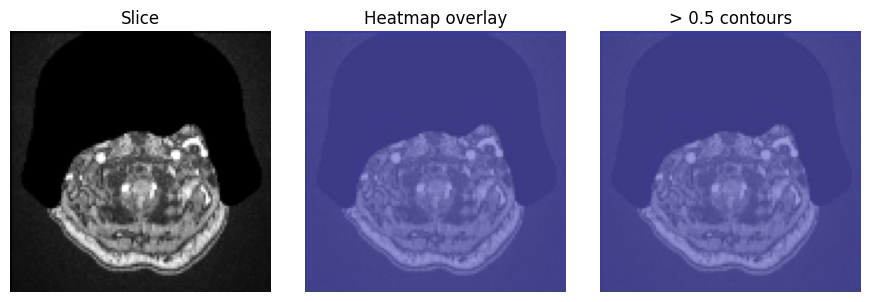

1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085 | label=0 | slice=1 | maxprob=0.109 | posfrac=0.0000 | n_comp=0


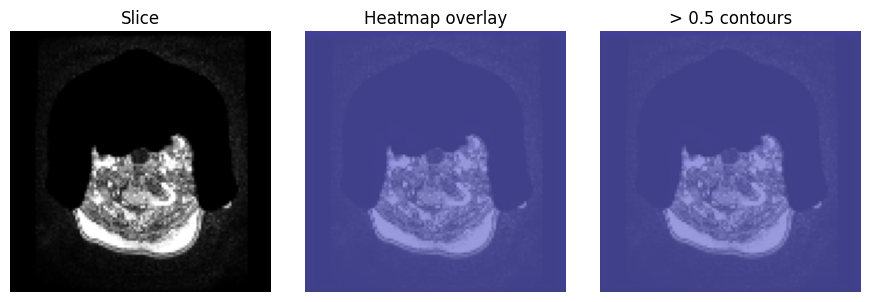

1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317 | label=1 | slice=44 | maxprob=0.183 | posfrac=0.0000 | n_comp=0


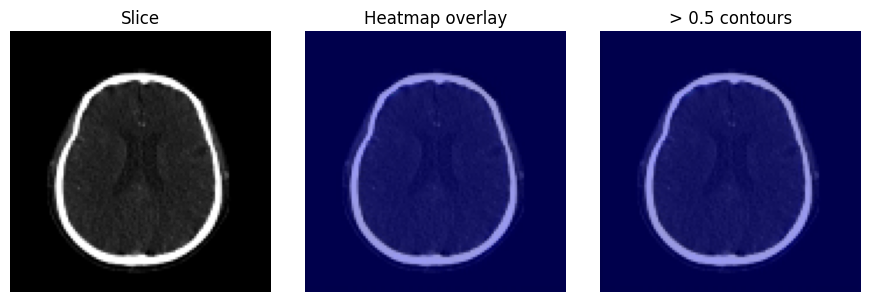

1.2.826.0.1.3680043.8.498.10009383108068795488741533244914370182 | label=0 | slice=1 | maxprob=0.110 | posfrac=0.0000 | n_comp=0


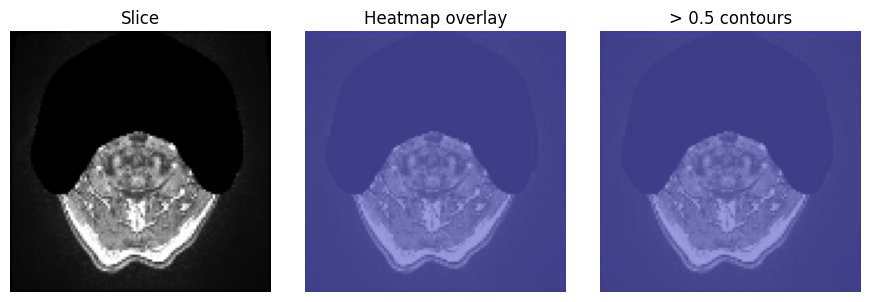

1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657 | label=0 | slice=18 | maxprob=0.112 | posfrac=0.0000 | n_comp=0


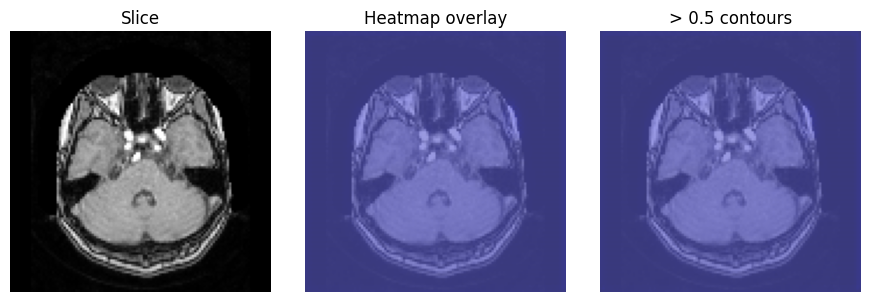

1.2.826.0.1.3680043.8.498.10014757658335054766479957992112625961 | label=0 | slice=1 | maxprob=0.163 | posfrac=0.0000 | n_comp=0


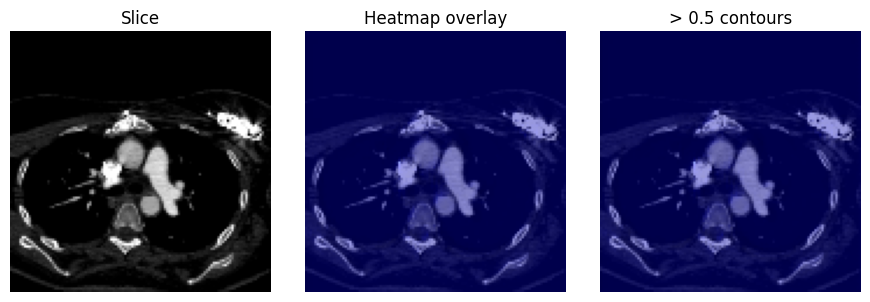

1.2.826.0.1.3680043.8.498.10021411248005513321236647460239137906 | label=0 | slice=39 | maxprob=0.134 | posfrac=0.0000 | n_comp=0


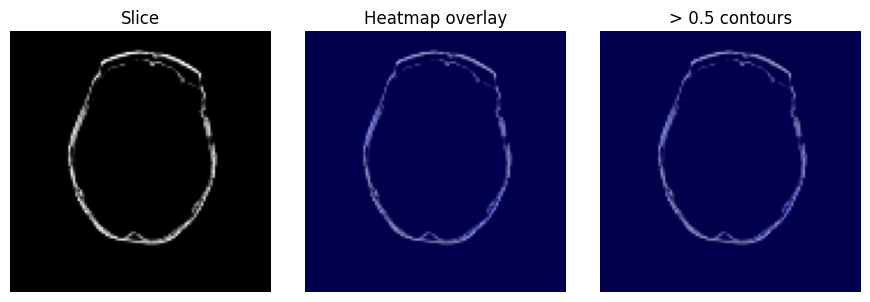

1.2.826.0.1.3680043.8.498.10022688097731894079510930966432818105 | label=0 | slice=1 | maxprob=0.110 | posfrac=0.0000 | n_comp=0


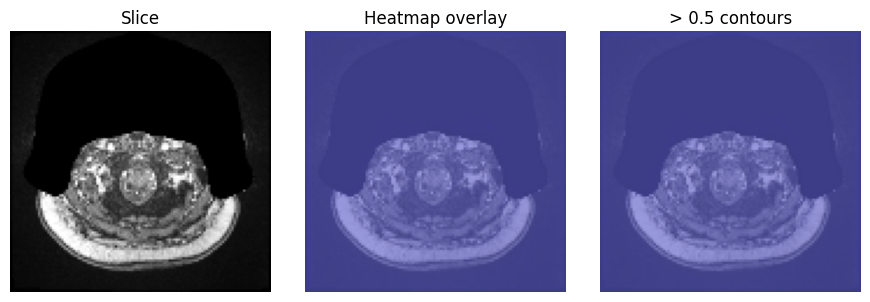

1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831 | label=1 | slice=1 | maxprob=0.170 | posfrac=0.0000 | n_comp=0


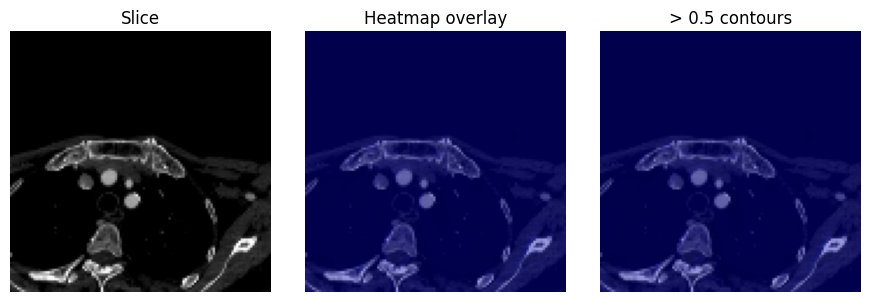

1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636 | label=1 | slice=1 | maxprob=0.111 | posfrac=0.0000 | n_comp=0


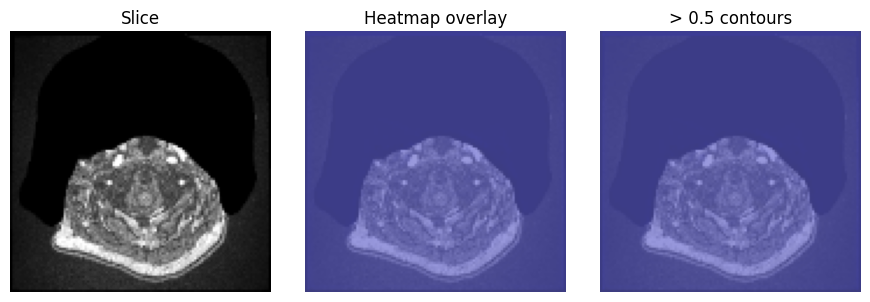

1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817 | label=1 | slice=34 | maxprob=0.124 | posfrac=0.0000 | n_comp=0


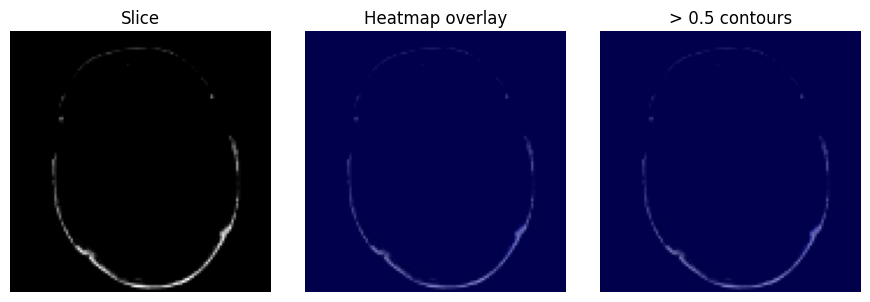

1.2.826.0.1.3680043.8.498.10030804647049037739144303822498146901 | label=0 | slice=1 | maxprob=0.109 | posfrac=0.0000 | n_comp=0


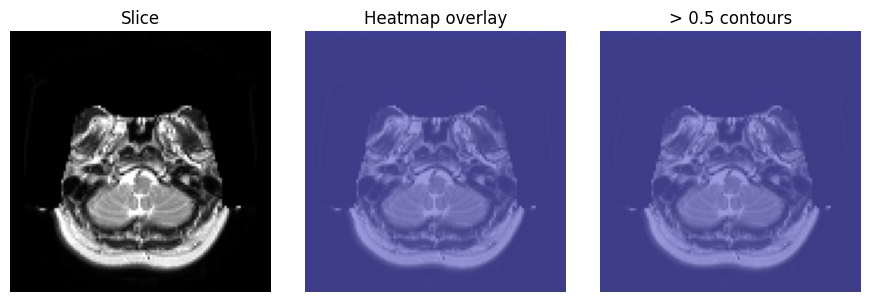

1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557 | label=1 | slice=27 | maxprob=0.149 | posfrac=0.0000 | n_comp=0


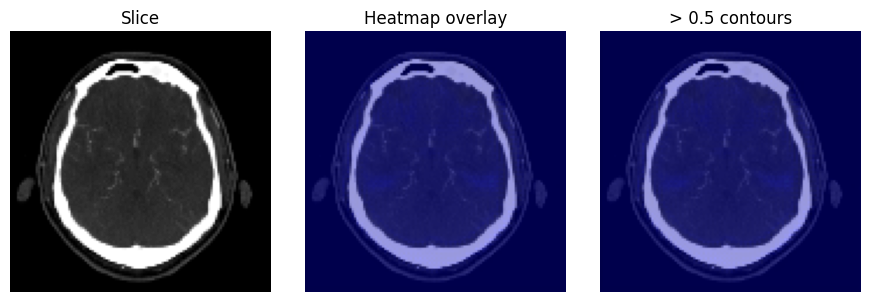

1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381 | label=1 | slice=24 | maxprob=0.153 | posfrac=0.0000 | n_comp=0


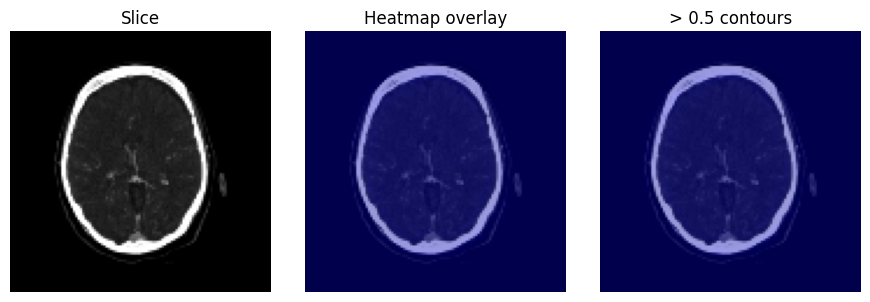

1.2.826.0.1.3680043.8.498.10035782880104673269567641444954004745 | label=0 | slice=1 | maxprob=0.109 | posfrac=0.0000 | n_comp=0


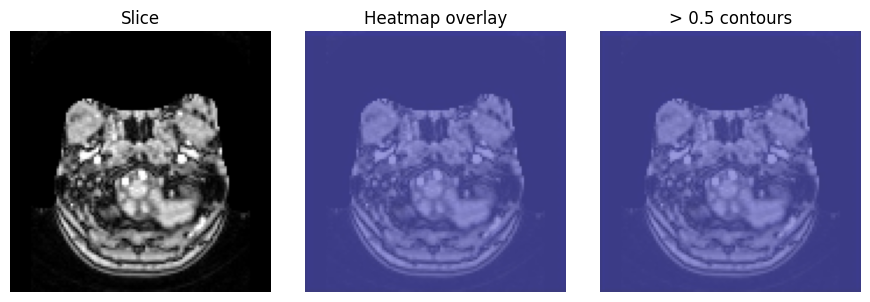

1.2.826.0.1.3680043.8.498.10037266473301611864455091971206084528 | label=0 | slice=1 | maxprob=0.111 | posfrac=0.0000 | n_comp=0


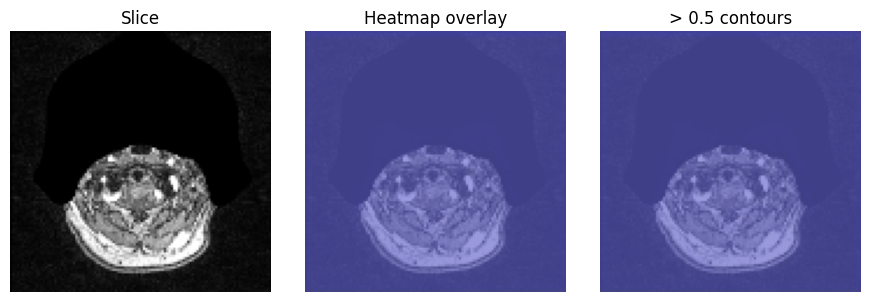

1.2.826.0.1.3680043.8.498.10040419508532196461125208817600495772 | label=0 | slice=1 | maxprob=0.109 | posfrac=0.0000 | n_comp=0


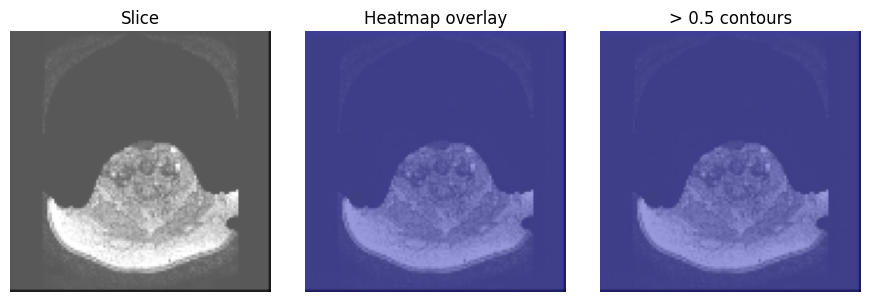

1.2.826.0.1.3680043.8.498.10042423585566957032411171949972906248 | label=1 | slice=1 | maxprob=0.110 | posfrac=0.0000 | n_comp=0


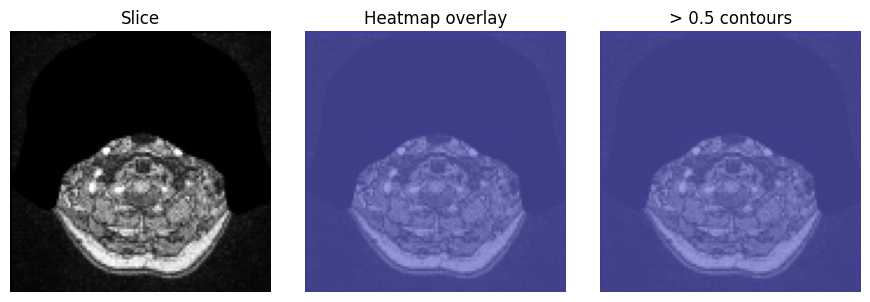

1.2.826.0.1.3680043.8.498.10042474696169267476037627878420766468 | label=1 | slice=15 | maxprob=0.140 | posfrac=0.0000 | n_comp=0


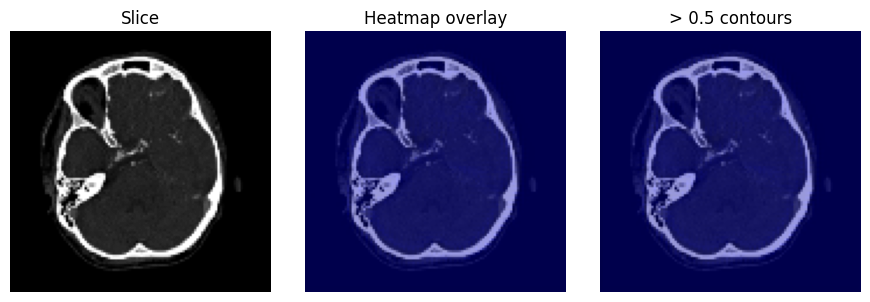

1.2.826.0.1.3680043.8.498.10046318991957083423208748012349179640 | label=0 | slice=1 | maxprob=0.106 | posfrac=0.0000 | n_comp=0


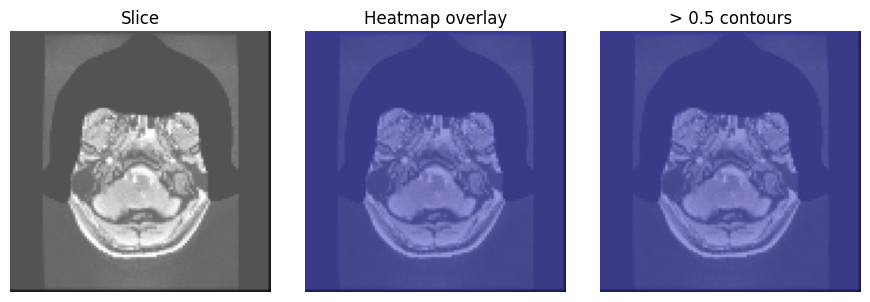

Saved visualizations to /kaggle/working for later inspection.


In [5]:
to_show = 20
shown = 0
thr = 0.5

for batch in val_loader_small:
    with torch.no_grad():
        vol = batch['volume'].to(device, non_blocking=True)
        seg_logits, cls_logits = model(vol)
        seg_prob = torch.sigmoid(seg_logits).float().cpu().numpy()  # [B,1,D,H,W]
        volumes = batch['volume'].float().cpu().numpy()              # [B,1,D,H,W]
    B = volumes.shape[0]
    for i in range(B):
        series_id = batch['series_id'][i]
        v = volumes[i, 0]  # [D,H,W]
        p = seg_prob[i, 0] # [D,H,W]

        # choose best slice by max predicted prob
        slice_idx = int(np.argmax(p.max(axis=(1, 2))))
        img = v[slice_idx]
        mask = p[slice_idx]

        # overlay heatmap
        overlay = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        heat = (np.clip(mask, 0, 1) * 255).astype(np.uint8)
        heat_color = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
        heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
        overlay_rgb = np.stack([overlay]*3, axis=-1)
        alpha = 0.4
        blended = ((1 - alpha) * overlay_rgb + alpha * heat_color).astype(np.uint8)

        # thresholded contours
        binmask = (mask > thr).astype(np.uint8)
        contours, _ = cv2.findContours(binmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        blended_contour = blended.copy()
        cv2.drawContours(blended_contour, contours, -1, (0, 255, 0), 1)

        # quick stats
        has_an = int(batch['has_aneurysm'][i].item())
        print(f"{series_id} | label={has_an} | slice={slice_idx} | maxprob={mask.max():.3f} | posfrac={binmask.mean():.4f} | n_comp={len(contours)}")

        # show and save
        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.axis('off'); plt.title('Slice')
        plt.subplot(1, 3, 2); plt.imshow(blended); plt.axis('off'); plt.title('Heatmap overlay')
        plt.subplot(1, 3, 3); plt.imshow(blended_contour); plt.axis('off'); plt.title(f'> {thr} contours')
        plt.tight_layout()
        out_path = f"/kaggle/working/viz_{series_id}_s{slice_idx}.png"
        plt.savefig(out_path, dpi=120, bbox_inches='tight'); plt.show()

        shown += 1
        if shown >= to_show:
            break
    if shown >= to_show:
        break

print("Saved visualizations to /kaggle/working for later inspection.")

In [6]:
from scipy import ndimage

def quick_3d_summary(prob_3d, thr=0.5):
    bin3d = (prob_3d > thr).astype(np.uint8)
    if bin3d.max() == 0:
        return dict(posfrac=0.0, n_comp=0, largest=0)
    lab, n = ndimage.label(bin3d)
    sizes = [(lab==i).sum() for i in range(1, n+1)]
    return dict(posfrac=bin3d.mean(), n_comp=n, largest=max(sizes) if sizes else 0)

# Example on first few from val_loader_small
with torch.no_grad():
    for batch in val_loader_small:
        vol = batch['volume'].to(device)
        seg_prob = torch.sigmoid(model(vol)[0]).float().cpu().numpy()
        for i in range(seg_prob.shape[0]):
            s = quick_3d_summary(seg_prob[i,0], thr=0.5)
            print(batch['series_id'][i], s)
        break

1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647 {'posfrac': 0.0, 'n_comp': 0, 'largest': 0}
1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085 {'posfrac': 0.0, 'n_comp': 0, 'largest': 0}
